# CPM Routing Optimization

# Load up the data 
* Demands = number of unpaid + expired
* locations = x,y coordinates of block
* labels = block id
* cars = average number of cars

## Data is from March 2017 to March 2018

In [172]:
import csv
import numpy as np
import os
demands = []
labels = []
locations = []
firstLine = True
limiter = 9999999
counter = 0
cars = []
megaCluster = []
streetSide = []
streetName = []
dataFolder = "data"
carTime = []
with open(os.path.join(dataFolder,'Input_Model_040318_newMC2_noDriving_CLZy_remSEblocks.csv'), 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if counter < limiter: #this is just a cap to QA the model with fewer locations
            if firstLine:
                firstLine = False
            else:
                latLong = []
                carTime.append(float(row[28]))
                latLong.append(float(row[23]))
                latLong.append(float(row[24]))
                locations.append(latLong)
                labels.append(row[1])
                demands.append(float(row[26]))
                cars.append(float(row[27]))
                megaCluster.append(int(row[25]))
                streetSide.append(row[14])
                streetName.append(row[18].split(" ",1)[1])
                counter+=1


start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)
zone = [int(x[4]) for x in labels]
np.bincount(np.array(zone))

array([   0, 1346,  456,  354,  662,  129,  539,  228,   14,   68])

In [155]:
import pandas as pd
dictionary = {'Block ID': labels, 'Unpaid and Expired Average': demands, 'Locations': locations}

df = pd.DataFrame.from_dict(dictionary)
df.head()

,Block ID,Locations,Unpaid and Expired Average
0,B202401,"[446902.8782, 4638107.972]",0.750000
1,B203401,"[448085.4775, 4638118.646]",0.067797
2,B203402,"[447920.0207, 4638116.64]",0.181818
3,B203403,"[447880.3523, 4638116.1]",0.179104
4,B203404,"[447720.1845, 4638114.725]",0.015152


# Next step - find optimal clusters of blocks for car drop-off
## Plotting locations below

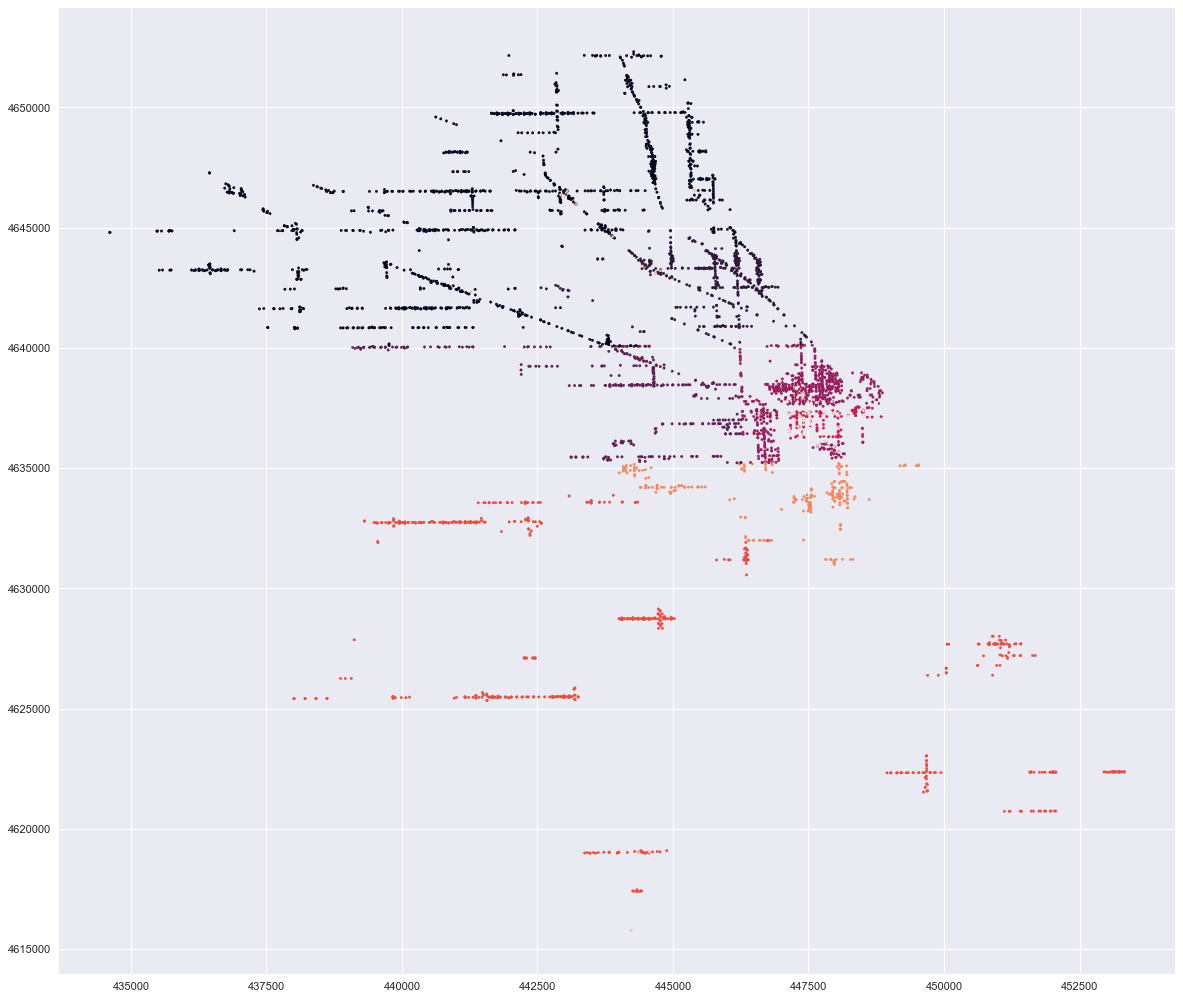

In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
seed = 1234 # setting seed to keep results the same run to run
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter([x[0] for x in locations], [x[1] for x in locations], s=5, c=zone)
# plt.figure(figsize=(200,100))

# Below we are trying to find the optimal number of clusters. 
This is found by iterating through clusters 1-50 and looking at the average number of blocks + the average distance of blocks from the center starting point of the cluster.

# UPDATE 3.14.18:

K means had some overlapping clusters - now moving to a density based cluster to get the clusters to make more sense geographically

Cluster Sizes: [1099   63   94   97   68  129  182   64   99  419  539  158  100  874]


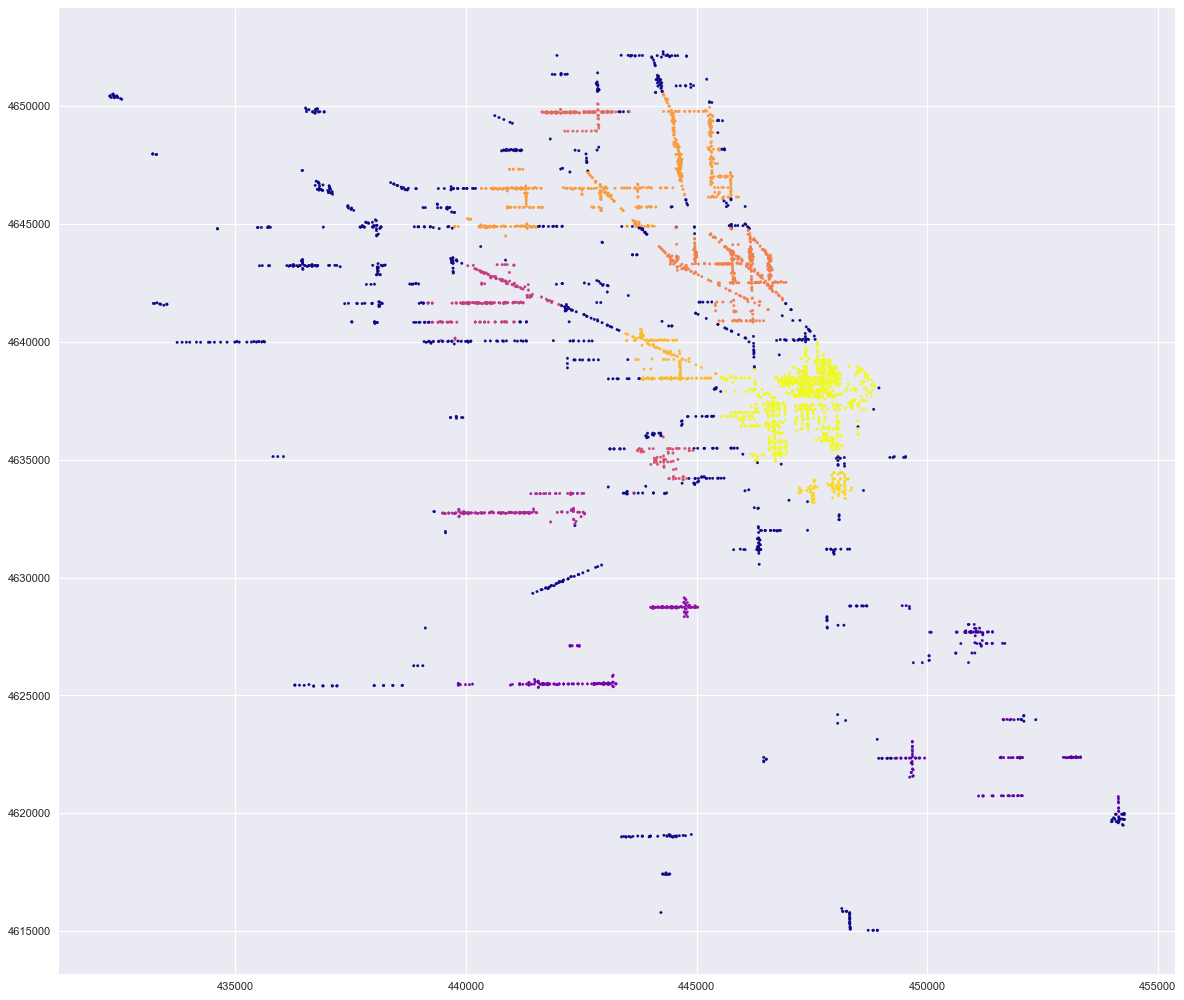

In [9]:
# Elbow chart
from scipy.cluster.vq import vq
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import hdbscan


X = np.array(zip([x[0] for x in locations],[x[1] for x in locations]))

clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
cluster_labels = clusterer.fit_predict(X)

hdbscanLabels = cluster_labels + 100 #IDS will be incremented by 100 - note that 99 aka -1 will use kmeans
cSizes = np.bincount(cluster_labels + 1)
print("Cluster Sizes: " + str(cSizes))

#need to find centroid of HDSCAN clusters

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

XX = np.column_stack((X, cluster_labels))
centers = []
for k in range(len(cSizes) - 1):
    ind = np.where(XX[:, 2] == k)
    locs = XX[ind, 0:1]
    cent = centeroidnp(locs)
    centers.append(cent)
centers = np.array(centers)
denseCenters = centers # save as another object
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=5, cmap='plasma')

# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5)

# Using the idea of downtown 'mega-cluster' where individuals walk from the LAZ garage

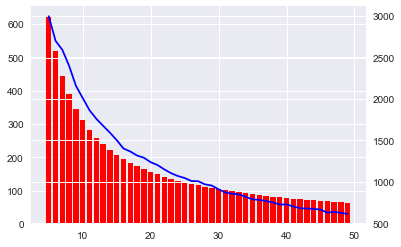

In [143]:
# omit from megacluster to find ideal clusters
mc = np.array(megaCluster)
distortions = []
avgBinsize = []
indexes = np.where(np.array(mc)[:] == 0)
Xzone = X[indexes]
K = range(5,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=seed).fit(Xzone)
    kmeanModel.fit(Xzone)
    distortions.append(sum(np.min(cdist(Xzone, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ Xzone.shape[0])
    centers = kmeanModel.cluster_centers_
    idx,_ = vq(Xzone,centers) #finding the number of blocks by cluster
    avgBinsize.append(np.average(np.bincount(idx)))
plt.bar(K, avgBinsize, color='r')
# for kb in zip(K,avgBinsize):|
#     plt.annotate('{}'.format(kb), xy=kb, textcoords='data')
axes2 = plt.twinx()
# print("Zone # {}".format(i))
plt.plot(K, distortions, 'bx-')
plt.show()
i+=1
# print(zip(K,avgBinsize, distortions))


# Now we are choosing the number of clusters and slicing the data by cluster
## kData is the data structure that will be used to hold the data by cluster, and eventually the solution
* center = the x,y coord that is the center of the cluster
* locations = the locations by cluster
* labels = block id by cluster
* cars = number of parked cars by cluster
* demand = number of unpaid + expired by cluster
* centralTerm = the blockID closest to the center

Cluster Sizes: [  0  54  43  41  28 124  52  38  82  68  84  79  81  59  31  89  68  10
  82  77  63  86  47  71  20  15  91 156  67  51  36  57  44  28  63  37
  56  26  37  80  59 122  29  55 104  19  65  56  82  58  15  33   8  21
   8  64  54  47  13  56  48]


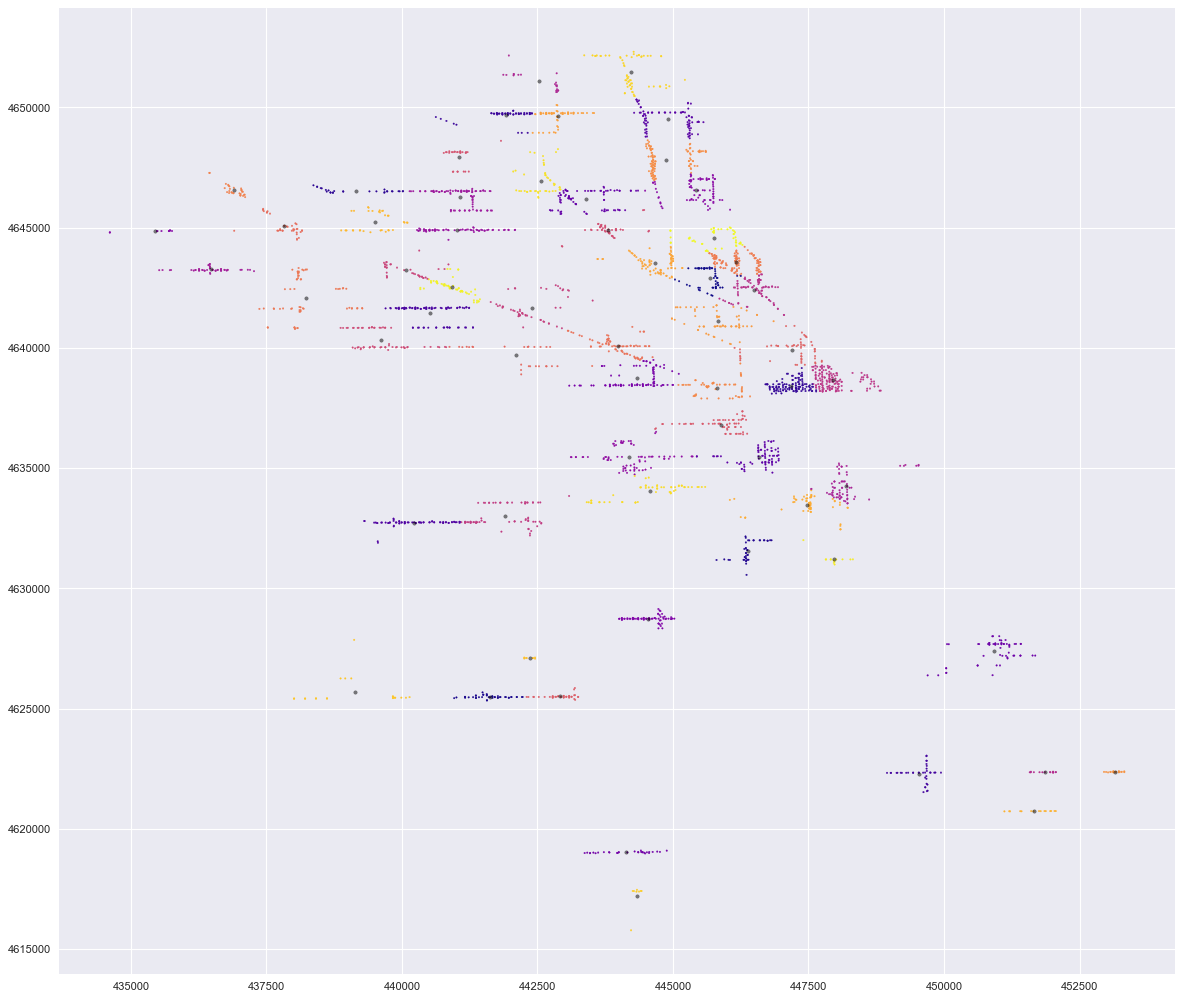

In [193]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np

seed = 1234

fullData = {'locations': locations, 'labels': labels, 'cars': cars, 'demands': demands\
            , 'megacluster': megaCluster, 'streetName' : streetName, \
            'streetSide': streetSide, 'carCheckTime': carTime}

fullDS = pd.DataFrame.from_dict(fullData)


nClusters = 60

kData ={key: {'center': None, 'locations': None, 'labels' : None, 'cars' : None, 'demand' : None,\
              'centralTerm': None} for key in range(nClusters)}

#now load up the megacluster first:

megaData = fullDS.loc[fullDS['megacluster'] == 1]
nonmegaData = fullDS.loc[fullDS['megacluster'] == 0]

megaDict = megaData.to_dict(orient='list')
nonMegaDict = nonmegaData.to_dict(orient='list')

X = np.array(zip([x[0] for x in nonMegaDict['locations']],[x[1] for x in nonMegaDict['locations']]))

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=nClusters, random_state=seed)
kmeans.fit(X)

kPred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=kPred, s=2, cmap='plasma')


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5)

# print np.average(np.bincount(idx))
closest, _ = pairwise_distances_argmin_min(centers, X)
centerTerminals = [nonMegaDict['labels'][c] for c in closest]
# kData ={key: {'center': None, 'locations': None, 'labels' : None, 'cars' : None, 'demand' : None,\
#               'centralTerm': None} for key in range(nClusters)}
# kData = {}
for k in range(nClusters):
    klocations = []
    klabels = []
    kcars = []
    kdemand = []
    kstreet = []
    kside = []
    kctime = []
    for loc, lab, car, dem, kp, sn, sd, cct in zip(nonMegaDict['locations'], nonMegaDict['labels'],\
                                      nonMegaDict['cars'], nonMegaDict['demands'], kPred,\
                                     nonMegaDict['streetName'], nonMegaDict['streetSide'], nonMegaDict['carCheckTime']):
        if kp == k:
            klocations.append(loc)
            klabels.append(lab)
            kcars.append(car)
            kdemand.append(dem)
            kstreet.append(sn)
            kside.append(sd)
            kctime.append(cct)
        
    kData[k].update({'center': centers[k], 'locations': klocations, 'labels': klabels, \
                    'cars': kcars, 'demand': kdemand, 'centralTerm': centerTerminals[k], \
                    'streetName': kstreet, 'streetSide': kside, 'carCheckTime': kctime})
#     print(len(klocations))


stuffThatIsDrivingMeNutsWPython = {'center': [448476.6, 4636929], 'locations': megaDict['locations'], \
                 'labels': megaDict['labels'], 'cars' : megaDict['cars'], 'demand': megaDict['demands'],\
                             'centralTerm' : "LAZ GARAGE", 'streetName': megaDict['streetName'],\
                                   'streetSide' : megaDict['streetSide'], 'carCheckTime': megaDict['carCheckTime']}
kData.update({nClusters  : stuffThatIsDrivingMeNutsWPython})
            
# kData[0]

#add megacluster 

            
cSizes = np.bincount(kPred + 1)
print("Cluster Sizes: " + str(cSizes))
# centers

In [5]:
#save cluster data to csv
import datetime
import pandas as pd
now = datetime.datetime.now()
dataFolder = "output"
filename = os.path.join(dataFolder, "clusterFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv")

nonmegaData["clusterID"] = kPred.tolist()
megaData["clusterID"] = [nClusters ] * len(megaData)

df = nonmegaData.append(megaData)
# se = pd.Series(kPred)
# se2 = pd.Series(cluster_labels)
# df = pd.DataFrame(np.column_stack((kPred, hdbscanLabels, np.array(labels))), columns=["kMeans", "HDBScan", "Block ID"])
# df

df.to_csv(filename)
df.head()

/Users/jwortz/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jwortz/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,carCheckTime,cars,demands,labels,locations,megacluster,streetName,streetSide,clusterID
0,21.907079,4.100000,1.433333,B101101,"[444454.5456, 4649832.168]",0,N CLARK ST,E,22
8,20.644830,2.637306,0.642487,B200410,"[446422.5006, 4637980.551]",0,N UNION AVE,W,7
19,25.532989,5.532609,1.135870,B202401,"[446902.8782, 4638107.972]",0,W ONTARIO ST,N,12
20,24.286204,0.684211,0.152047,B202403,"[446823.2882, 4638095.383]",0,N KINGSBURY ST,E,12
21,25.704341,2.061350,0.576687,B202404,"[447001.1648, 4638106.519]",0,W ONTARIO ST,S,12


# Street Crossing Function

* Short term - finding if there is one crossing immediatly
* Long term - finding the longer crossings

In [122]:
def ShortTermCrossing(xCurrent, yCurrent, sideCurrent, xLast, yLast, sideLast):
#     assign directions
    goSouth = yLast > yCurrent
    goNorth = yLast < yCurrent
    goEast = xLast < xCurrent
    goWest = xLast > xCurrent
    goSW = goSouth and goWest
    goSE = goSouth and goEast
    goNE = goNorth and goEast
    goNW = goNorth and goWest
    xWalk = abs(xCurrent - xLast)
    yWalk = abs(yCurrent - yLast)
    distance = xWalk + yWalk
    
        ##conditions for crossing n,s,e,w
    
    if sideLast == "N" and sideCurrent == "S" and goSouth:
        r=1
    elif sideLast == "S" and sideCurrent == "N" and goNorth:
        r=1
    elif sideLast == "E" and sideCurrent == "W" and goWest:
        r=1
    elif sideLast == "W" and sideCurrent == "E" and goEast:
        r=1
        
    ###SAME SIDES
    elif sideLast == "N" and sideCurrent == "N" and yWalk > 50:
        r=1
    elif sideLast == "S" and sideCurrent == "S" and yWalk > 50:
        r=1
    elif sideLast == "E" and sideCurrent == "E" and xWalk > 50:
        r=1
    elif sideLast == "W" and sideCurrent == "W" and xWalk > 50:
        r=1
        
        
    #diagonals
    elif sideLast == "N" and sideCurrent == "E" and (goSouth or goEast):
        r=1
    elif sideLast == "N" and sideCurrent == "W" and (goSouth or goWest):
        r=1
    elif sideLast == "S" and sideCurrent == "E" and (goNorth or goEast):
        r=1
    elif sideLast == "S" and sideCurrent == "W" and (goNorth or goWest):
        r=1
    elif sideLast == "W" and sideCurrent == "N" and (goEast or goNorth):
        r=1
    elif sideLast == "W" and sideCurrent == "S" and (goEast or goSouth):
        r=1
    elif sideLast == "E" and sideCurrent == "N" and (goWest or goNorth):
        r=1
    elif sideLast == "E" and sideCurrent == "S" and (goWest or goSouth):
        r=1

    else:
        r=0
    return r
        
def LongTermCrossings(blockSizeX, blockSizeY, xCurrent, yCurrent, xLast, yLast):
    xWalk = abs(xCurrent - xLast)
    yWalk = abs(yCurrent - yLast)
    xBlocks = math.floor(xWalk / blockSizeX)
    yBlocks = math.floor(yWalk / blockSizeY)
    return xBlocks + yBlocks
        

# Create objects and callback functions for optimization algorithm
* distance = manhattan distance function
* distanceCallback = distance function from previous to current block
* demandCallback = get the paid + unpaid for the current block
* ServiceTimeCallback = get the time per ticket written
* CarCheckCallback = get the time it takes to check each indivisual car
* travelTimeCallback = get the travel time from node to node assuming a speed
* totalTimeCallback = the total time for the block, adding the various time callbacks + block overhead time assumptions

## Update 3.25.18 - added street name/side callback
## Also updated the distance callback to include a distance penalty + time penalty



In [123]:
import math
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def distance(x1, y1, x2, y2):
    # Manhattan distance
    dist = abs(x1 - x2) + abs(y1 - y2)

    return dist

# Distance callback

class CreateDistanceCallback(object):
  """Create callback to calculate distances and travel times between points."""

  def __init__(self, locations, street_name, street_side, cross_penalty, blockSizeX, blockSizeY):
    """Initialize distance array."""
    num_locations = len(locations)
    self.matrix = {}
    self.crossings = {}

    for from_node in xrange(num_locations):
      self.matrix[from_node] = {}
      self.crossings[from_node] = {}
      for to_node in xrange(num_locations):
#             JSW: THIS ALLOWS O TRAVEL PENALTY FROM DEPOT
#         if from_node == depot or to_node == depot:
#           self.matrix[from_node][to_node] = 0
#         else:
          x1 = locations[from_node][0]
          y1 = locations[from_node][1]
          x2 = locations[to_node][0]
          y2 = locations[to_node][1]
          #self.matrix[from_node][to_node] = distance(x1, y1, x2, y2)
          #### adding the street crossing penalty
          streetFrom = street_name[from_node]
          streetTo = street_name[to_node]
          sideFrom = street_side[from_node]
          sideTo = street_side[to_node]

#########changing up new street crossing function 3.30.18 JSW
          stXing = ShortTermCrossing(x2, y2, sideTo, x1, y1, sideFrom)
          ltXing = LongTermCrossings(blockSizeX, blockSizeY, x2, y2, x1, y1)
          totalCrossings = stXing + ltXing
          self.crossings[from_node][to_node] = totalCrossings
#           x_penalty = cross_penalty * totalCrossings
#############END OF DISTANCE BASED UPDATE
          self.matrix[from_node][to_node] = distance(x1, y1, x2, y2)# + x_penalty

  def Distance(self, from_node, to_node):
     return self.matrix[from_node][to_node]
    
  def Crossings(self, from_node, to_node):
     return self.crossings[from_node][to_node]


# Demand callback
class CreateDemandCallback(object):
  """Create callback to get demands at location node."""

  def __init__(self, demands):
    self.matrix = demands

  def Demand(self, from_node, to_node):
    return self.matrix[from_node]


####STREET NAME ADDED 3/25/18

class CreateStreetCrossingCallback(object):
    
    def __init__(self, street_name, street_side, crossingPenalty, locations, blockSizeX, blockSizeY):
        self.matrix = zip(street_name, street_side, locations)
#         self.street_direction = street_direction
        self.crossing_penalty = crossingPenalty
        self.blockSizeX = blockSizeX
        self.blockSizeY = blockSizeY
    
    def CrossingPenalty(self, from_node, to_node):
          sideFrom = self.matrix[from_node][1]
          sideTo = self.matrix[to_node][1]
          x1 = self.matrix[from_node][2][0]
          y1 = self.matrix[from_node][2][1]
          x2 = self.matrix[to_node][2][0]
          y2 = self.matrix[to_node][2][1]
          stXing = ShortTermCrossing(x2, y2, sideTo, x1, y1, sideFrom)
          ltXing = LongTermCrossings(self.blockSizeX, self.blockSizeY, x2, y2, x1, y1)
          return self.crossing_penalty * (stXing + ltXing)
#             if self.matrix[from_node][0] == self.matrix[to_node][0]\
#             and self.matrix[from_node][1] != self.matrix[to_node][1]:
#                 return int(self.crossing_penalty)
#             else:
#                 return int(0)
#         except:
#             0
        
        
        
# Service time (proportional to demand) callback.
class CreateServiceTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, demands, time_per_demand_unit):
    self.matrix = demands
    self.time_per_demand_unit = time_per_demand_unit

  def ServiceTime(self, from_node, to_node):
#     return int(self.matrix[from_node] * self.time_per_demand_unit)
    return self.matrix[from_node] * self.time_per_demand_unit

######JSW ADD BLOCK OVERHEAD TIME

class CreateBlockOverheadTime(object):
  """Create callback to get overhead time for each block."""

  def __init__(self, overhead_time):
    self.matrix = demands
    self.overhead_time = overhead_time

  def BlockOverheadTime(self, from_node, to_node):
    return int(self.overhead_time)


####################

######JSW ADD NONVIOLATOR CHECK TIME
# Service time (proportional to demand) callback.
##### UPDATED 4.3.18 - now just loads the car time from dataset
class CreateCarCheckTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, carCheckTime, cars):
    self.matrix = zip(carCheckTime, cars)
#     self.time_per_car_unit = time_per_car_unit

  def ServiceTime(self, from_node, to_node):
    return int(self.matrix[from_node][0] * self.matrix[from_node][1])
#####################################

# Create the travel time callback (equals distance divided by speed).
class CreateTravelTimeCallback(object):
  """Create callback to get travel times between locations."""

  def __init__(self, dist_callback, speed):
    self.dist_callback = dist_callback
    self.speed = speed

  def TravelTime(self, from_node, to_node):
    travel_time = self.dist_callback(from_node, to_node) / self.speed
    return int(travel_time)
# Create total_time callback (equals service time plus travel time).
class CreateTotalTimeCallback(object):
  """Create callback to get total times between locations."""

  def __init__(self, service_time_callback, travel_time_callback, car_check_time_callback, \
              overhead_time_callback, street_crossing_callback):
    self.service_time_callback = service_time_callback
    self.travel_time_callback = travel_time_callback
    self.car_check_time_callback = car_check_time_callback
    self.overhead_time_callback = overhead_time_callback
    self.street_crossing_callback = street_crossing_callback

  def TotalTime(self, from_node, to_node):
    service_time = self.service_time_callback(from_node, to_node)
    travel_time = self.travel_time_callback(from_node, to_node)
    car_check_time = self.car_check_time_callback(from_node, to_node)
    overhead_time = self.overhead_time_callback(from_node, to_node)
    street_crossing_time = self.street_crossing_callback(from_node, to_node)
    return service_time + travel_time + car_check_time + overhead_time + street_crossing_time

def get_routes_array(assignment, num_routes, routing):
  # Get the routes for an assignent and return as a list of lists.
  routes = []
  for route_nbr in range(num_routes):
    node = routing.Start(route_nbr)
    route = []

    while not routing.IsEnd(node):
      node = assignment.Value(routing.NextVar(node))
      route.append(node)
    routes.append(route)
  return routes

In [124]:
#creating objects for function to work below
depot = 0
labs = ['a','b']
street_side = ["N", "E"]
cct = []
street_name = ["a", "b"]

# Below is the optimization algorithm and function
## key parameters:
* locations = list of locations
* demands = paid + unpaid
* start times, end times = the time windows of a given block's availability... currently not used
* num_vehicles = number of enforcement agents
* search time limit = limit in ms of time to find a solution
* time per demand unit = time it takes to write a ticket
* speed = walking speed between blocks
* vehicle capacity = maximum tickets that can be written - not used aka: unlimited
* depot = the index of the block where everyone starts walking for their shift
* horizion = shift duration
* time per car unit = time it takes to check each car (regardles of if there is a ticket)
* labs = block ids
* cars = number of cars

# Updates to new parameters iteration 2, 3

* street name = list of street names, number stripped
* street side = N,S,E,W side of the street
* distance constraint = the total cap of distance an individual can walk in a cycle
* block size x, y = size in meters of a block, used to identify street crossings
* distanceCrossing penalty = this decides if we use distance or time as the penalty for crossing streets, default is distance
* street crossing penalty = the time in seconds we penalize street crossings. It can either be translated into additional distance in the model or additional time. adding in to distance creates some double counting of travel time problems


In [125]:
def parktimize(locations=locations, demands=demands, start_times=start_times, end_times=end_times, \
         num_vehicles=30, search_time_limit = 2000,\
        horizon = 6.5 * 3600, time_per_demand_unit = 3*60, speed = 1.34, VehicleCapacity = 999999,\
        depot = depot, time_per_car_unit=cct, labs=labs, cars=cars, blockOverhead = 2 * 60, \
         street_crossing_penalty = 60, street_name=street_name, street_side=street_side, \
         distance_constraint = 20922, blockSizeX = int(0.3048 * 600), blockSizeY = int(0.3048 * 600) ,\
         distanceCrossingPenalty = False):

  num_locations = len(locations)

  if num_locations > 0:

    # The number of nodes of the VRP is num_locations.
    # Nodes are indexed from 0 to num_locations - 1. By default the start of
    # a route is node 0.
    routing = pywrapcp.RoutingModel(num_locations, num_vehicles, depot)
    search_parameters = pywrapcp.RoutingModel_DefaultSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING) ## added by jw for search
    search_parameters.time_limit_ms = search_time_limit #added by jsw
    search_parameters.first_solution_strategy = (
                                    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC) #added by jsw
    #JW ADD - make sure all nodes will be reached
    #routing.AddAllActive
    ## Added 3.28 for street crossing to be done by speed
    if distanceCrossingPenalty:
        cross_dist = street_crossing_penalty * speed
    else:
        cross_dist = 0
    # Callbacks to the distance function and travel time functions here.
    dist_between_locations = CreateDistanceCallback(locations, street_name, street_side, cross_dist, blockSizeX, \
                                                   blockSizeY)
    dist_callback = dist_between_locations.Distance
    crossing_callback = dist_between_locations.Crossings

    routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    demands_at_locations = CreateDemandCallback(demands)
    demands_callback = demands_at_locations.Demand


    NullCapacitySlack = 0;
    fix_start_cumul_to_zero = True
    capacity = "Unpaid and Overdue"

    routing.AddDimension(demands_callback, NullCapacitySlack, VehicleCapacity,
                         fix_start_cumul_to_zero, capacity)
    # Add time dimension.

    time = "Total Time"
    
    if distanceCrossingPenalty: #this disables the adding of time for crossing
        street_crossing_penalty = 0 #hack to not double add
#     self, street_name, street_side, crossingPenalty, locations, blockSizeX, blockSizeY
    street_crossing_times = CreateStreetCrossingCallback(street_name, street_side, street_crossing_penalty, \
                                                        locations, blockSizeX, blockSizeY)
    street_crossing_callback = street_crossing_times.CrossingPenalty

    service_times = CreateServiceTimeCallback(demands, time_per_demand_unit)
    service_time_callback = service_times.ServiceTime
    
    car_check_time = CreateCarCheckTimeCallback(cars, cct)
    car_check_time_callback = car_check_time.ServiceTime
    
    block_overhead_time = CreateBlockOverheadTime(blockOverhead)
    block_overhead_time_callback = block_overhead_time.BlockOverheadTime

    travel_times = CreateTravelTimeCallback(dist_callback, speed)
    travel_time_callback = travel_times.TravelTime

    total_times = CreateTotalTimeCallback(service_time_callback, travel_time_callback,\
                                           car_check_time_callback, block_overhead_time_callback, \
                                         street_crossing_callback)
    total_time_callback = total_times.TotalTime
    dist_slack = 0
    ### added distance constraint
    routing.AddDimension(dist_callback,  # total time function callback
                         distance_constraint,
                         distance_constraint + dist_slack,
                         fix_start_cumul_to_zero,
                         "Total Distance")
    
    
    crossing_constraint = 999999999
    routing.AddDimension(crossing_callback,  # total crossings callback
                         crossing_constraint,
                         crossing_constraint,
                         fix_start_cumul_to_zero,
                         "Total Crossings")
    
    routing.AddDimension(street_crossing_callback,  # total crossings callback
                         crossing_constraint,
                         crossing_constraint,
                         fix_start_cumul_to_zero,
                         "Total Crossings Time")
    
    routing.AddDimension(total_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         fix_start_cumul_to_zero,
                         time)
    routing.AddDimension(travel_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Travel Time")
    routing.AddDimension(street_crossing_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Street Crossing Time")
    routing.AddDimension(service_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Ticket Writing Time")
    routing.AddDimension(car_check_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Car Checking Time")
    routing.AddDimension(block_overhead_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         False,
                         "Block Checkin Time")

#     JSW - removed the time windows
#     for location in range(1, num_locations):
#       start = start_times[location]
#       end = end_times[location]
#       time_dimension.CumulVar(location).SetRange(start, end)
    # Solve displays a solution if any.
    assignment = routing.SolveWithParameters(search_parameters)
    
    if assignment:
      size = len(locations)
      # Solution cost.
      print "Total distance of all routes: " + str(assignment.ObjectiveValue()) + "\n"
      # Inspect solution.
      capacity_dimension = routing.GetDimensionOrDie(capacity);
      time_dimension = routing.GetDimensionOrDie(time);
      travel_time = routing.GetDimensionOrDie("Travel Time")
      street_crossing_time = routing.GetDimensionOrDie("Street Crossing Time")
      ticket_writing_time = routing.GetDimensionOrDie("Ticket Writing Time")
      car_checking_time = routing.GetDimensionOrDie("Car Checking Time")
      block_checkin_time = routing.GetDimensionOrDie("Block Checkin Time")
      crossings = routing.GetDimensionOrDie("Total Crossings")
      street_crossing_time = routing.GetDimensionOrDie("Street Crossing Time")
      total_distance = routing.GetDimensionOrDie("Total Distance")
    
      solByCar = []
      for vehicle_nbr in range(num_vehicles):
        nodeSolution = []
        ticketLoad = []
        tminArr = []
        travTime = []
        scTime = []
        twTime = []
        ccTime = []
        bcTime = []
        totCrossings = []
        scTime = []
        ctTime = []
        tDist = []
#         tmaxArr = []
        index = routing.Start(vehicle_nbr)
        plan_output = 'Route {0}:'.format(vehicle_nbr)

        while not routing.IsEnd(index):
          node_index = routing.IndexToNode(index)
          load_var = capacity_dimension.CumulVar(index)
          trav_var = travel_time.CumulVar(index)
          time_var = time_dimension.CumulVar(index)
          street_cross_var = street_crossing_time.CumulVar(index)
          ticket_write_var = ticket_writing_time.CumulVar(index)
          car_check_var = car_checking_time.CumulVar(index)
          block_check_var = block_checkin_time.CumulVar(index)
          crossings_var = crossings.CumulVar(index)
          ct_var = street_crossing_time.CumulVar(index)
          dis_var = total_distance.CumulVar(index)
          plan_output += \
                    " {node_index} Load({load}) Time({tmin}) -> ".format(
                        node_index=labs[node_index],
                        load=assignment.Value(load_var),
                        tmin=str(assignment.Min(time_var)))
#                         ,
#                         tmax=str(assignment.Max(time_var)))
          index = assignment.Value(routing.NextVar(index))
          nodeSolution.append(labs[node_index])
          ticketLoad.append(assignment.Value(load_var))
          travTime.append(assignment.Value(trav_var))
          scTime.append(assignment.Value(street_cross_var))
          twTime.append(assignment.Value(ticket_write_var))
          ccTime.append(assignment.Value(car_check_var))
          bcTime.append(assignment.Value(block_check_var))
          tminArr.append(str(assignment.Value(time_var)))
          totCrossings.append(assignment.Value(crossings_var))
          ctTime.append(assignment.Value(ct_var))
          tDist.append(assignment.Value(dis_var))
#           tmaxArr.append(str(assignment.Max(time_var)))

        node_index = routing.IndexToNode(index)
        load_var = capacity_dimension.CumulVar(index)
        time_var = time_dimension.CumulVar(index)
        plan_output += \
                  " {node_index} Load({load}) Time({tmin})".format(
                      node_index=labs[node_index],
                      load=assignment.Value(load_var),
                      tmin=str(assignment.Min(time_var)))
#                       ,
#                       tmax=str(assignment.Max(time_var)))
        print plan_output
        solByCar.append((nodeSolution, ticketLoad, tminArr, travTime, twTime, ccTime, bcTime,\
                         totCrossings, ctTime, tDist))
        print "\n"
        print routing.CostVar()
      return solByCar, assignment
    else:
      print 'No solution found.'
  else:
    print 'Specify an instance greater than 0.'

# Below is an example of running the optimization for one cluster

12
B265607
B206601
39


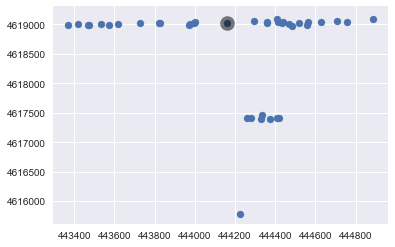

In [174]:
from sklearn.metrics import pairwise_distances_argmin_min # to find closest terminal to center

clustData = kData[13]
loc = clustData['locations']
dem = clustData['demand']
start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)
labs = clustData['labels']
depot = labs.index(clustData['centralTerm']) # find the starting drop-off point
cct = clustData['carCheckTime']
ca = clustData['cars']
street_name = clustData['streetName']
street_side = clustData['streetSide']
print(depot)
print(clustData['centralTerm'])
print(labs[0])
print(len(loc))


X = np.array(zip([x[0] for x in loc],[x[1] for x in loc]))

plt.scatter(X[:, 0], X[:, 1])
# print(ca)
# print(dem)
# centers = kmeans.cluster_centers_
plt.scatter(loc[depot][0], loc[depot][1], c='black', s=200, alpha=0.5)


# Run the optimization

## Output is in the following format:

Route PERSON ID Load CUMUALTIVE NUMBER OF TICKETS Time SECONDS FROM START -> NEXT NODE

In [175]:
# Establish running parameters of model
noEmps = 10
params = {'locations': loc, 'demands':dem, 'start_times':start_times, 'end_times':end_times, \
                 'num_vehicles':noEmps, 'search_time_limit': 500,'horizon' : int(3.1 * 3600), \
                 'time_per_demand_unit' : 2*60, 'speed' : 1.34, 'VehicleCapacity' : 999999,\
                'depot' : depot, 'time_per_car_unit':cct, 'labs':labs, 'cars' : ca, 'blockOverhead' : 2*60, \
          'street_crossing_penalty' : 60, 'street_name':street_name, 'street_side':street_side, \
         'distance_constraint': 9999999, 'blockSizeX' : int(0.3048 * 600), 'blockSizeY' : int(0.3048 * 600) ,\
         'distanceCrossingPenalty' : False} #20922

In [177]:
solByCar, assignment = parktimize(**params)


Total distance of all routes: 10604

Route 0: B265607 Load(0) Time(0) ->  B265607 Load(1) Time(342)


Cost(0..9223372036854775807)
Route 1: B265607 Load(0) Time(0) ->  B265607 Load(1) Time(342)


Cost(0..9223372036854775807)
Route 2: B265607 Load(0) Time(0) ->  B265607 Load(1) Time(342)


Cost(0..9223372036854775807)
Route 3: B265607 Load(0) Time(0) ->  B265607 Load(1) Time(342)


Cost(0..9223372036854775807)
Route 4: B265607 Load(0) Time(0) ->  B265607 Load(1) Time(342)


Cost(0..9223372036854775807)
Route 5: B265607 Load(0) Time(0) ->  B265607 Load(1) Time(342)


Cost(0..9223372036854775807)
Route 6: B265607 Load(0) Time(0) ->  B265607 Load(1) Time(342)


Cost(0..9223372036854775807)
Route 7: B265607 Load(0) Time(0) ->  B266618 Load(1) Time(463) ->  B266621 Load(2) Time(776) ->  B266616 Load(5) Time(1413) ->  B266612 Load(6) Time(2214) ->  B266608 Load(6) Time(2577) ->  B266620 Load(6) Time(2872) ->  B266619 Load(6) Time(3234) ->  B266607 Load(6) Time(3412) ->  B266610 Load(7) Time(3

In [13]:
#  FIELDS: solByCar.append((nodeSolution, ticketLoad, tminArr, travTime, twTime, ccTime, bcTime, totCrossings))


def getDataForAgent(x):
    solX = solByCar[x]
    solDict = {'locations': solX[0], 'time': solX[2], 'travel time':solX[3], 'ticket writing time': solX[4] ,\
              'car checking time': solX[5], 'block checkin time':solX[6],'crossing time':solX[8],\
               'crossings': solX[7], 'tickets': solX[1], 'total distance': solX[9]}
    return pd.DataFrame.from_dict(solDict)

getDataForAgent(7)

,block checkin time,car checking time,crossing time,crossings,locations,ticket writing time,tickets,time,total distance,travel time
0,0,0,0,0,B467106,0,0,0,0,0
1,120,28,60,1,B468107,33,0,534,393,293
2,240,65,120,2,B468104,63,0,871,514,383
3,360,120,120,2,B468115,183,1,1213,578,430
4,480,135,180,3,B468116,183,1,1418,591,440
5,600,161,180,3,B468117,243,1,1668,651,484
6,720,217,240,4,B468102,273,1,1939,658,489
7,840,299,240,4,B920107,372,1,2411,887,660
8,960,432,300,5,B920106,529,2,2899,911,678
9,1080,576,300,5,B920105,700,3,3402,1002,746


# How to fix redundant depot visit? create dummy depot staring point based on closest location with 0 ticket demand

# WARNING - DO NOT RUN THIS MORE THAN ONCE, OR IT WILL KEEP APPENDING NEW LIST ITEMS

In [178]:
def getData(cluster):
    clustData = kData[cluster]
    loc = clustData['locations']
    dem = clustData['demand']
    labs = clustData['labels']
    ca = clustData['cars']
    street_side = clustData['streetSide']
    street_name = clustData['streetName']
    cct = clustData['carCheckTime']
    #TODO: implement the LAZ GARAGE IF CLUSTERID = N-CLUSTERS
    if cluster == nClusters:
        loc.append([448476.6, 4636929])
        dem.append(0)
        ca.append(0)
        cct.append(0)
        labs.append('starting by termial: LAZ GARAGE')
        street_name.append("NA")
        street_side.append("NA")
        depot = len(loc) - 1

    #begin appending of dummy start point
    else:
        loc.append(loc[labs.index(clustData['centralTerm'])])
        dem.append(0)
        ca.append(0)
        cct.append(0)
        labs.append('starting by termial: ' + clustData['centralTerm'])
        street_name.append(street_name[labs.index(clustData['centralTerm'])])
        street_side.append(street_side[labs.index(clustData['centralTerm'])])
        depot = len(loc) - 1
    start_times =  [0] * len(demands)
    end_times = [3600 * 24] * len(start_times)
    return loc, dem, ca, labs, depot, start_times, end_times, street_name, street_side, cct
loc, dem, ca, labs, depot, start_times, end_times, street_name, street_side, cct = getData(2)

   # The empUp function loops through number of enforcement agents until it finds the minimal viable needed employees per cluster

In [201]:
def empUp(start = 0):    
    noEmps = start
    solByCar = None
    while solByCar is None and noEmps < 50:
        try:
            noEmps += 1
            print("trying # of employees : " + str(noEmps))
            solByCar, assignment = parktimize(num_vehicles=noEmps, locations=loc, demands=dem, \
        start_times=start_times, end_times=end_times, search_time_limit = 500,\
        horizon = int(2.017 * 3600), time_per_demand_unit = 2*60, speed = 1.34,\
        depot = depot, time_per_car_unit=cct, labs=labs, cars=ca, blockOverhead = 2 * 60, \
         street_crossing_penalty = 60, street_name=street_name, street_side=street_side, \
         distance_constraint = int(1609.344 * 12), blockSizeX = int(0.3048 * 600), blockSizeY = int(0.3048 * 600))
        except:
             pass
    return solByCar, noEmps
# 2.017 mega/night
# 2.2 neighborhood
# 24.5 n street crossing
# 660 x 330 n block

# Now run the optimization for all clusters

In [202]:
k = nClusters
print("Starting cluster {} of {}".format(k, nClusters))
loc, dem, ca, labs, depot, start_times, end_times, street_name, street_side, cct = getData(k)
solution, noEmps = empUp(0)
kData[k].update({'solution': solution, 'empsNeeded': noEmps})

Starting cluster 60 of 60
trying # of employees : 1
No solution found.
trying # of employees : 2
No solution found.
trying # of employees : 3
No solution found.
trying # of employees : 4
No solution found.
trying # of employees : 5
No solution found.
trying # of employees : 6
No solution found.
trying # of employees : 7
No solution found.
trying # of employees : 8
No solution found.
trying # of employees : 9
No solution found.
trying # of employees : 10
No solution found.
trying # of employees : 11
No solution found.
trying # of employees : 12
No solution found.
trying # of employees : 13
No solution found.
trying # of employees : 14
No solution found.
trying # of employees : 15
No solution found.
trying # of employees : 16
No solution found.
trying # of employees : 17
No solution found.
trying # of employees : 18
No solution found.
trying # of employees : 19
No solution found.
trying # of employees : 20
No solution found.
trying # of employees : 21
No solution found.
trying # of emplo

In [194]:
for k in range( nClusters):
# k = nClusters
    print("Starting cluster {} of {}".format(k, nClusters))
    loc, dem, ca, labs, depot, start_times, end_times, street_name, street_side, cct = getData(k)
    solution, noEmps = empUp()
    kData[k].update({'solution': solution, 'empsNeeded': noEmps})

Starting cluster 0 of 60
trying # of employees : 1
No solution found.
trying # of employees : 2
No solution found.
trying # of employees : 3
Total distance of all routes: 7712

Route 0: starting by termial: B444212 Load(0) Time(0) ->  B444201 Load(0) Time(218) ->  B444208 Load(0) Time(430) ->  B444204 Load(0) Time(948) ->  B445216 Load(0) Time(1295) ->  B445215 Load(0) Time(1518) ->  B445205 Load(1) Time(1959) ->  B445206 Load(1) Time(2134) ->  B445207 Load(1) Time(2336) ->  B445212 Load(1) Time(2569) ->  B445208 Load(1) Time(2888) ->  B445211 Load(1) Time(3039) ->  B445218 Load(1) Time(3258) ->  B445210 Load(1) Time(3440) ->  B445209 Load(1) Time(3722) ->  B428201 Load(1) Time(3969) ->  B339206 Load(1) Time(5075) ->  B339203 Load(1) Time(5502) ->  B339208 Load(1) Time(5999) ->  B339201 Load(1) Time(6288) ->  B444212 Load(1) Time(7263) ->  starting by termial: B444212 Load(1) Time(7494)


Cost(0..9223372036854775807)
Route 1: starting by termial: B444212 Load(0) Time(0) ->  B444209 Loa

Cost(0..9223372036854775807)
Route 2: starting by termial: B243413 Load(0) Time(0) ->  B816903 Load(0) Time(340) ->  B243402 Load(0) Time(597) ->  B243403 Load(0) Time(859) ->  B816905 Load(0) Time(1073) ->  B242410 Load(0) Time(1327) ->  B242405 Load(0) Time(1663) ->  B242403 Load(0) Time(1978) ->  B243405 Load(0) Time(2266) ->  B236413 Load(0) Time(2598) ->  B237401 Load(0) Time(2894) ->  B242414 Load(0) Time(3122) ->  B242408 Load(1) Time(3558) ->  B241403 Load(2) Time(3981) ->  B242404 Load(2) Time(4192) ->  B242402 Load(2) Time(4480) ->  B242407 Load(2) Time(4789) ->  B242401 Load(2) Time(5053) ->  B242406 Load(2) Time(5381) ->  B242411 Load(2) Time(5626) ->  B243410 Load(2) Time(5913) ->  B816904 Load(2) Time(6335) ->  B243404 Load(2) Time(6577) ->  B243407 Load(2) Time(6824) ->  B243408 Load(3) Time(7335) ->  starting by termial: B243413 Load(3) Time(7695)


Cost(0..9223372036854775807)
Route 3: starting by termial: B243413 Load(0) Time(0) ->  B244415 Load(0) Time(222) ->  B2444


Cost(0..9223372036854775807)
Route 3: starting by termial: B436115 Load(0) Time(0) ->  B435115 Load(0) Time(266) ->  B435113 Load(0) Time(486) ->  B435105 Load(0) Time(787) ->  B435106 Load(0) Time(1098) ->  B435123 Load(0) Time(1285) ->  B435108 Load(0) Time(1472) ->  B435109 Load(1) Time(1841) ->  B435110 Load(1) Time(1995) ->  B434101 Load(1) Time(2203) ->  B434102 Load(1) Time(2497) ->  B434103 Load(1) Time(2659) ->  B434104 Load(1) Time(2830) ->  B434114 Load(1) Time(3136) ->  B434105 Load(1) Time(3422) ->  B434118 Load(1) Time(3605) ->  B434107 Load(1) Time(3803) ->  B434108 Load(1) Time(4039) ->  B434119 Load(1) Time(4271) ->  B434110 Load(1) Time(4478) ->  B434111 Load(1) Time(4777) ->  B434112 Load(1) Time(5008) ->  B434113 Load(1) Time(5205) ->  B434120 Load(1) Time(5456) ->  B434116 Load(1) Time(5625) ->  B434117 Load(1) Time(5807) ->  B435111 Load(1) Time(6078) ->  B435121 Load(2) Time(6542) ->  B435117 Load(2) Time(6830) ->  B435118 Load(2) Time(6992) ->  starting by term

Route 2: starting by termial: B286422 Load(0) Time(0) ->  B285405 Load(0) Time(435) ->  B620709 Load(0) Time(762) ->  B620701 Load(0) Time(936) ->  B620707 Load(0) Time(1311) ->  B620705 Load(0) Time(1532) ->  B621703 Load(0) Time(1885) ->  B621704 Load(0) Time(2331) ->  B621701 Load(0) Time(2658) ->  B285401 Load(1) Time(3063) ->  B285408 Load(1) Time(3236) ->  B529410 Load(1) Time(3443) ->  B529405 Load(1) Time(3668) ->  B529407 Load(3) Time(4463) ->  B632403 Load(4) Time(5060) ->  B631401 Load(4) Time(5397) ->  B631402 Load(4) Time(5579) ->  B529402 Load(4) Time(5939) ->  B529401 Load(4) Time(6161) ->  B529412 Load(4) Time(6469) ->  B532405 Load(4) Time(6714) ->  B529413 Load(4) Time(6914) ->  B529404 Load(4) Time(7216) ->  starting by termial: B286422 Load(4) Time(7826)


Cost(0..9223372036854775807)
Route 3: starting by termial: B286422 Load(0) Time(0) ->  B286422 Load(0) Time(120) ->  B286418 Load(0) Time(447) ->  B286424 Load(0) Time(613) ->  B286419 Load(0) Time(786) ->  B53440

Cost(0..9223372036854775807)
Route 1: starting by termial: B265607 Load(0) Time(0) ->  B265607 Load(0) Time(120) ->  B266601 Load(1) Time(613) ->  B266615 Load(1) Time(1010) ->  B266602 Load(2) Time(1366) ->  B266603 Load(3) Time(1794) ->  B266613 Load(3) Time(2174) ->  B266610 Load(3) Time(2443) ->  B266607 Load(4) Time(2906) ->  B266619 Load(5) Time(3252) ->  B266620 Load(5) Time(3483) ->  B266608 Load(5) Time(3742) ->  B266612 Load(5) Time(4069) ->  B266616 Load(5) Time(4624) ->  B266621 Load(6) Time(5031) ->  B266618 Load(9) Time(5629) ->  starting by termial: B265607 Load(10) Time(6035)


Cost(0..9223372036854775807)
Starting cluster 14 of 60
trying # of employees : 1
No solution found.
trying # of employees : 2
No solution found.
trying # of employees : 3
No solution found.
trying # of employees : 4
No solution found.
trying # of employees : 5
Total distance of all routes: 12478

Route 0: starting by termial: B297308 Load(0) Time(0) ->  B297314 Load(0) Time(171) ->  B297309 Load(


Cost(0..9223372036854775807)
Route 2: starting by termial: L107802 Load(0) Time(0) ->  L107802 Load(0) Time(120) ->  B467120 Load(0) Time(670) ->  B467121 Load(0) Time(1030) ->  B921105 Load(1) Time(1469) ->  B921104 Load(1) Time(1821) ->  B921106 Load(1) Time(2179) ->  B921108 Load(2) Time(2617) ->  B921103 Load(2) Time(2908) ->  B921102 Load(2) Time(3174) ->  B465104 Load(2) Time(3498) ->  B465107 Load(2) Time(3790) ->  B466103 Load(2) Time(4228) ->  B466104 Load(2) Time(4492) ->  B467119 Load(2) Time(4908) ->  starting by termial: L107802 Load(2) Time(5187)


Cost(0..9223372036854775807)
Route 3: starting by termial: L107802 Load(0) Time(0) ->  B467102 Load(0) Time(262) ->  B467124 Load(1) Time(754) ->  B467115 Load(1) Time(1003) ->  B467113 Load(1) Time(1366) ->  B467111 Load(1) Time(1734) ->  B467110 Load(1) Time(1963) ->  B467104 Load(1) Time(2174) ->  B468110 Load(1) Time(2594) ->  B468108 Load(1) Time(2921) ->  B468107 Load(1) Time(3231) ->  B468113 Load(1) Time(3490) ->  B468

Route 1: starting by termial: B500114 Load(0) Time(0) ->  B519112 Load(0) Time(431) ->  B519102 Load(0) Time(664) ->  B520104 Load(0) Time(1478) ->  B520101 Load(0) Time(1917) ->  B520117 Load(0) Time(2176) ->  B520116 Load(0) Time(2461) ->  B520102 Load(0) Time(2673) ->  B520103 Load(0) Time(2948) ->  B520115 Load(0) Time(3285) ->  B520114 Load(0) Time(3608) ->  B520113 Load(0) Time(3889) ->  B520112 Load(0) Time(4147) ->  B520106 Load(0) Time(4436) ->  B520107 Load(0) Time(4767) ->  B520111 Load(0) Time(5011) ->  B520110 Load(0) Time(5322) ->  B520108 Load(0) Time(5571) ->  B520126 Load(0) Time(5912) ->  B520127 Load(0) Time(6119) ->  B520109 Load(0) Time(6284) ->  B500111 Load(0) Time(7141) ->  B500110 Load(0) Time(7380) ->  starting by termial: B500114 Load(1) Time(7886)


Cost(0..9223372036854775807)
Route 2: starting by termial: B500114 Load(0) Time(0) ->  B519113 Load(0) Time(432) ->  B519115 Load(0) Time(639) ->  B519114 Load(0) Time(855) ->  B499112 Load(0) Time(1056) ->  B499

Route 1: starting by termial: B480119 Load(0) Time(0) ->  B480119 Load(0) Time(120) ->  B480121 Load(0) Time(438) ->  B480122 Load(1) Time(978) ->  B480123 Load(1) Time(1214) ->  B480101 Load(1) Time(1382) ->  B480102 Load(1) Time(1564) ->  B480103 Load(1) Time(1712) ->  B480104 Load(1) Time(1947) ->  B480105 Load(1) Time(2190) ->  B480106 Load(1) Time(2353) ->  B480160 Load(2) Time(2777) ->  starting by termial: B480119 Load(2) Time(3056)


Cost(0..9223372036854775807)
Starting cluster 24 of 60
trying # of employees : 1
Total distance of all routes: 1048

Route 0: starting by termial: B394604 Load(0) Time(0) ->  B394604 Load(0) Time(120) ->  B394609 Load(1) Time(460) ->  B394602 Load(2) Time(855) ->  B394605 Load(2) Time(1159) ->  B394608 Load(2) Time(1455) ->  B394607 Load(2) Time(1720) ->  B394606 Load(2) Time(1979) ->  B394615 Load(2) Time(2583) ->  B394614 Load(2) Time(2835) ->  B394601 Load(5) Time(3454) ->  B394613 Load(6) Time(3863) ->  B394612 Load(8) Time(4381) ->  B394611 Lo

Route 3: starting by termial: B222408 Load(0) Time(0) ->  B222404 Load(0) Time(213) ->  B235416 Load(0) Time(612) ->  B235404 Load(0) Time(840) ->  B235418 Load(0) Time(1169) ->  B235405 Load(0) Time(1340) ->  B235406 Load(0) Time(1574) ->  B235407 Load(0) Time(1793) ->  B234405 Load(0) Time(2032) ->  B234408 Load(0) Time(2353) ->  B234402 Load(0) Time(2573) ->  B234407 Load(0) Time(2841) ->  B234401 Load(0) Time(3108) ->  B226403 Load(0) Time(3556) ->  B234403 Load(0) Time(3798) ->  B234404 Load(0) Time(4036) ->  B226407 Load(0) Time(4237) ->  B225405 Load(0) Time(4512) ->  B225403 Load(0) Time(4787) ->  B225402 Load(0) Time(5122) ->  B225404 Load(0) Time(5351) ->  B224403 Load(0) Time(5635) ->  B223405 Load(0) Time(5960) ->  B223403 Load(0) Time(6198) ->  B222405 Load(0) Time(6465) ->  starting by termial: B222408 Load(0) Time(6740)


Cost(0..9223372036854775807)
Route 4: starting by termial: B222408 Load(0) Time(0) ->  B246407 Load(0) Time(300) ->  B246408 Load(0) Time(607) ->  B246

trying # of employees : 2
No solution found.
trying # of employees : 3
Total distance of all routes: 7032

Route 0: starting by termial: B349106 Load(0) Time(0) ->  B309105 Load(0) Time(374) ->  B309104 Load(1) Time(711) ->  B309106 Load(1) Time(946) ->  B309103 Load(2) Time(1324) ->  B309108 Load(2) Time(1611) ->  B309109 Load(4) Time(2065) ->  B309102 Load(4) Time(2318) ->  B309110 Load(4) Time(2549) ->  B309120 Load(4) Time(2764) ->  B309113 Load(4) Time(3054) ->  B309112 Load(4) Time(3357) ->  B309111 Load(6) Time(3788) ->  B309107 Load(6) Time(4091) ->  starting by termial: B349106 Load(6) Time(4788)


Cost(0..9223372036854775807)
Route 1: starting by termial: B349106 Load(0) Time(0) ->  B349105 Load(0) Time(344) ->  B304101 Load(2) Time(944) ->  B304110 Load(2) Time(1208) ->  B304103 Load(2) Time(1486) ->  B304102 Load(2) Time(1753) ->  B304104 Load(3) Time(2200) ->  B304105 Load(3) Time(2412) ->  B304107 Load(3) Time(2691) ->  B304108 Load(3) Time(3007) ->  B304109 Load(3) Time(

Cost(0..9223372036854775807)
Route 2: starting by termial: B258311 Load(0) Time(0) ->  B731312 Load(0) Time(349) ->  B731313 Load(0) Time(639) ->  B731314 Load(0) Time(978) ->  B731303 Load(0) Time(1319) ->  B731304 Load(0) Time(1582) ->  B905407 Load(0) Time(1991) ->  B257413 Load(0) Time(2460) ->  B638434 Load(0) Time(3057) ->  B638401 Load(0) Time(3347) ->  B713316 Load(0) Time(3947) ->  B257411 Load(1) Time(4512) ->  B905405 Load(1) Time(4898) ->  B905406 Load(1) Time(5326) ->  B731315 Load(1) Time(5602) ->  B258301 Load(1) Time(6090) ->  B258312 Load(1) Time(6320) ->  B258302 Load(1) Time(6682) ->  B258303 Load(1) Time(7034) ->  B358304 Load(1) Time(7363) ->  starting by termial: B258311 Load(1) Time(7744)


Cost(0..9223372036854775807)
Route 3: starting by termial: B258311 Load(0) Time(0) ->  B258311 Load(0) Time(120) ->  B258304 Load(0) Time(416) ->  starting by termial: B258311 Load(0) Time(673)


Cost(0..9223372036854775807)
Starting cluster 34 of 60
trying # of employees : 1


Cost(0..9223372036854775807)
Route 2: starting by termial: B302328 Load(0) Time(0) ->  B301304 Load(0) Time(321) ->  B301303 Load(0) Time(504) ->  B301310 Load(0) Time(715) ->  B301301 Load(0) Time(1146) ->  B301315 Load(1) Time(1782) ->  B300313 Load(1) Time(2046) ->  B300322 Load(1) Time(2419) ->  B300314 Load(1) Time(2748) ->  B300311 Load(1) Time(2964) ->  B301313 Load(1) Time(3698) ->  B301312 Load(1) Time(3939) ->  B301311 Load(1) Time(4142) ->  B301309 Load(1) Time(4542) ->  starting by termial: B302328 Load(1) Time(4990)


Cost(0..9223372036854775807)
Route 3: starting by termial: B302328 Load(0) Time(0) ->  B716104 Load(0) Time(513) ->  B716142 Load(0) Time(768) ->  B716102 Load(0) Time(965) ->  B716112 Load(0) Time(1431) ->  B716118 Load(0) Time(1825) ->  B716116 Load(0) Time(2318) ->  B716127 Load(1) Time(3096) ->  B716143 Load(1) Time(3534) ->  B716126 Load(1) Time(3807) ->  B716124 Load(1) Time(4235) ->  B716114 Load(1) Time(4753) ->  B716107 Load(2) Time(5786) ->  B716101

trying # of employees : 2
Total distance of all routes: 3585

Route 0: starting by termial: B506118 Load(0) Time(0) ->  B506113 Load(0) Time(213) ->  B506109 Load(0) Time(1253) ->  B506108 Load(0) Time(1401) ->  B506107 Load(0) Time(2332) ->  B506106 Load(0) Time(2522) ->  B506105 Load(0) Time(2785) ->  B506117 Load(0) Time(2990) ->  starting by termial: B506118 Load(0) Time(3260)


Cost(0..9223372036854775807)
Route 1: starting by termial: B506118 Load(0) Time(0) ->  B506118 Load(0) Time(120) ->  B506115 Load(0) Time(340) ->  B506111 Load(0) Time(613) ->  B505104 Load(0) Time(908) ->  B505103 Load(0) Time(1209) ->  B505105 Load(0) Time(1501) ->  B505106 Load(0) Time(1770) ->  B505107 Load(0) Time(1984) ->  B505121 Load(0) Time(2236) ->  B505119 Load(0) Time(2576) ->  B505109 Load(0) Time(2791) ->  B505120 Load(0) Time(2963) ->  B505111 Load(0) Time(3133) ->  B505112 Load(0) Time(3354) ->  B505113 Load(0) Time(3749) ->  B505114 Load(0) Time(3877) ->  B505116 Load(0) Time(4141) ->  B505

Route 0: starting by termial: B399605 Load(0) Time(0) ->  B399605 Load(0) Time(120) ->  B399618 Load(0) Time(383) ->  B399604 Load(0) Time(635) ->  B399602 Load(0) Time(936) ->  B399601 Load(1) Time(1270) ->  B399619 Load(1) Time(1489) ->  B399603 Load(1) Time(1750) ->  B399617 Load(1) Time(2007) ->  B399616 Load(1) Time(2283) ->  B399615 Load(1) Time(2536) ->  B399613 Load(1) Time(2835) ->  B399612 Load(1) Time(3087) ->  B399610 Load(1) Time(3386) ->  B399609 Load(1) Time(3636) ->  B399611 Load(1) Time(3930) ->  B399608 Load(1) Time(4191) ->  B399607 Load(2) Time(4534) ->  B399606 Load(2) Time(4788) ->  B399614 Load(2) Time(5089) ->  starting by termial: B399605 Load(2) Time(5349)


Cost(0..9223372036854775807)
Starting cluster 45 of 60
trying # of employees : 1
No solution found.
trying # of employees : 2
No solution found.
trying # of employees : 3
No solution found.
trying # of employees : 4
Total distance of all routes: 13421

Route 0: starting by termial: B333204 Load(0) Time(0) 

No solution found.
trying # of employees : 3
No solution found.
trying # of employees : 4
Total distance of all routes: 11626

Route 0: starting by termial: B535719 Load(0) Time(0) ->  B535719 Load(0) Time(120) ->  B535713 Load(0) Time(440) ->  B535711 Load(1) Time(957) ->  B555701 Load(1) Time(1509) ->  B555706 Load(1) Time(1968) ->  B557710 Load(2) Time(3641) ->  B557712 Load(2) Time(3984) ->  B555709 Load(2) Time(5114) ->  B555710 Load(2) Time(5404) ->  B555711 Load(2) Time(5563) ->  B535726 Load(2) Time(6652) ->  B535723 Load(2) Time(7221) ->  B535709 Load(2) Time(7449) ->  starting by termial: B535719 Load(2) Time(7901)


Cost(0..9223372036854775807)
Route 1: starting by termial: B535719 Load(0) Time(0) ->  B535705 Load(0) Time(162) ->  B535704 Load(0) Time(398) ->  B535724 Load(1) Time(932) ->  B602703 Load(1) Time(1625) ->  B352708 Load(1) Time(1918) ->  B352707 Load(1) Time(2078) ->  B352703 Load(1) Time(2365) ->  B352701 Load(1) Time(2672) ->  B912703 Load(1) Time(3116) ->  B9

trying # of employees : 3
No solution found.
trying # of employees : 4
Total distance of all routes: 9247

Route 0: starting by termial: B362716 Load(0) Time(0) ->  B362718 Load(0) Time(438) ->  B362705 Load(0) Time(718) ->  B362707 Load(0) Time(1106) ->  B622705 Load(1) Time(2150) ->  B629707 Load(1) Time(2668) ->  B624705 Load(1) Time(2956) ->  B362717 Load(1) Time(3455) ->  B362704 Load(1) Time(3639) ->  B362710 Load(1) Time(3942) ->  B362702 Load(2) Time(4408) ->  B363709 Load(3) Time(4938) ->  B362714 Load(5) Time(5589) ->  B364701 Load(6) Time(6136) ->  B363707 Load(7) Time(6485) ->  B364717 Load(8) Time(7196) ->  starting by termial: B362716 Load(8) Time(7596)


Cost(0..9223372036854775807)
Route 1: starting by termial: B362716 Load(0) Time(0) ->  B359612 Load(0) Time(825) ->  B359613 Load(0) Time(990) ->  B359614 Load(0) Time(1162) ->  B359619 Load(0) Time(1545) ->  B359620 Load(0) Time(1746) ->  B359601 Load(0) Time(2176) ->  B359611 Load(0) Time(2511) ->  B359603 Load(0) Time

# Write the solutions to file

In [ ]:
import pickle
import datetime

now = datetime.datetime.now()

filename = "solutionFile" + now.strftime("%Y-%m-%d %H:%M") + ".pickle"
with open(filename, 'wb') as handle:
    pickle.dump(kData, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(filename + " saved")

In [203]:
#         solByCar.append((nodeSolution, ticketLoad, tminArr, travTime, twTime, ccTime, bcTime))

# {'locations': solX[0], 'time': solX[2], 'travel time':solX[3], 'ticket writing time': solX[4] ,\
#               'car checking time': solX[5], 'block checkin time':solX[6],'crossing time':solX[8],\
#                'crossings': solX[7], 'tickets': solX[1], 'total distance': solX[9]}

time_per_ticket = 2*60
bid = []
time = []
personID = 1
people = []
clus = []
origin = []
ro = []
travTime = []
blockCheckTime = []
ticketWritingTime = []
carCheckTime = []
tickets = []
crossings = []
xTime = []
dist = []

# for k in range(nClusters + 1):
#     try:
k = nClusters
for person in kData[k]['solution']:
    o = []
    for p in person[0]:
        if p.startswith("starting"):
            o.append("True")
        else:
            o.append("False")
    origin.extend(o)
    rr = range(len(person[0]))
    ro.extend(rr)
    bid.extend(person[0])
    time.extend(person[2])
    travTime.extend(person[3])
    blockCheckTime.extend(person[6])
    crossings.extend(person[7])
    ticketWritingTime.extend(person[4])
    carCheckTime.extend(person[5])
    tickets.extend([x / time_per_ticket for x in person[4]])
    xTime.extend(person[8])
    dist.extend(person[9])
    pp = [personID] * len(person[0])
    people.extend(pp)
    personID += 1
    clusta = [k] * len(person[0])
    clus.extend(clusta)
#     except:
#         pass
len(people)

503

In [204]:

import pickle
import datetime

now = datetime.datetime.now()
finalDFDict = {'origin_flg': origin, 'Cluster ID': clus, 'Route ID': people, \
               'Block ID': bid, 'Expected Time': time, "Route ID": people, "RouteOrder": ro, \
              'travel time': travTime, 'block check time': blockCheckTime, 'ticket writing time': ticketWritingTime,\
              'car check time': carCheckTime, 'total tickets': tickets, 'street crossings' : crossings, \
              'crossing time': xTime, 'distance': dist}


finalData = pd.DataFrame.from_dict(finalDFDict)


filename = os.path.join("output", "routeFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv")

finalData.to_csv(filename)

finalData

,Block ID,Cluster ID,Expected Time,Route ID,RouteOrder,block check time,car check time,crossing time,distance,origin_flg,street crossings,ticket writing time,total tickets,travel time
0,starting by termial: LAZ GARAGE,60,0,1,0,0,0,0,0,True,0,0,0,0
1,B200401,60,3154,1,1,120,0,900,2860,False,15,0,0,2134
2,B200405,60,3626,1,2,240,114,960,2979,False,16,89,0,2223
3,B200403,60,3878,1,3,360,139,1020,3011,False,17,113,0,2246
4,starting by termial: LAZ GARAGE,60,0,2,0,0,0,0,0,True,0,0,0,0
5,B200411,60,2763,2,1,120,0,780,2497,False,13,0,0,1863
6,B200415,60,3395,2,2,240,109,840,2820,False,14,102,0,2104
7,B200414,60,3614,2,3,360,115,900,2860,False,15,105,0,2134
8,B200406,60,4063,2,4,480,149,960,3115,False,16,150,1,2324
9,starting by termial: LAZ GARAGE,60,0,3,0,0,0,0,0,True,0,0,0,0


In [ ]:
finalData.groupby('Cluster ID')['Route ID'].nunique()
